In [1]:
import logging
logging.basicConfig(level=logging.WARN)

import math
from copy import copy

import gym

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.metrics import population_metrics
from lcs.agents.acs2 import ACS2
from lcs.strategies.action_selection import BestAction, EpsilonGreedy, KnowledgeArray, ActionDelay

from utils.experiments import avg_experiments
from utils.plotting import COLORS

import numpy as np

from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

rc('pdf', **{'fonttype': 42})
rc('ps', **{'fonttype': 42})
rc('font',**{'family':'sans-serif', 'sans-serif': ['DejaVu Sans'],'size': 14})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # comment if you don't have high-res display

## Experiment settings

In [2]:
buckets = (1, 1, 3, 12)  # orig: (1, 1, 3, 6)

experiments = 50

explore_trials = 500
exploit_trials = 500

## Environment

In [3]:
env = gym.make('CartPole-v0')

In [4]:
# https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947
# _high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
# _low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]

_high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], 3500]
_low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -3500]

_high, _low

([4.8, 0.5, 0.41887903, 3500], [-4.8, -0.5, -0.41887903, -3500])

### Phenotype adapter (discretizer)

In [5]:
class CartPoleAdapter(EnvironmentAdapter):
    @classmethod
    def to_genotype(cls, obs):
        ratios = [(obs[i] + abs(_low[i])) / (_high[i] - _low[i]) for i in range(len(obs))]
        new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return [str(o) for o in new_obs]
    
# debug
CartPoleAdapter.to_genotype([0, 0, 0, 0])

['0', '0', '1', '6']

In [6]:
def cp_metrics(pop, env):
    metrics = {}
    metrics.update(population_metrics(pop, env))
    
    return metrics

In [7]:
base_params = {
    "classifier_length": 4,
    "number_of_possible_actions": 2,
    "epsilon": 0.9,
    "beta": 0.01,
    "gamma": 0.995,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "chi": 0.0,  # do not cross-over
    "mu": 0.03,
    "metrics_trial_frequency": 2,
    "environment_adapter": CartPoleAdapter,
    "user_metrics_collector_fcn": cp_metrics
}

### Epsilon Greedy (baseline)

In [8]:
%%time

epsilon_greedy_params = copy(base_params)
epsilon_greedy_params['action_selector'] = EpsilonGreedy
epsilon_greedy_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **epsilon_greedy_params)

{'classifier_length': 4, 'number_of_possible_actions': 2, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.995, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x118630290>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Executing experiment 22
Executing experi

### Action Delay Bias

In [9]:
%%time

action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **action_delay_params)

{'classifier_length': 4, 'number_of_possible_actions': 2, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.995, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x118630290>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.ActionDelay.ActionDelay'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Executing ex

### Knowledge Array Bias

In [10]:
%%time

knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **knowledge_array_params)

{'classifier_length': 4, 'number_of_possible_actions': 2, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.995, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x118630290>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.KnowledgeArray.KnowledgeArray'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Execut

### Optimistic Initial Quality

In [11]:
%%time

op_initial_params = copy(base_params)
op_initial_params['action_selector'] = EpsilonGreedy
op_initial_params['initial_q'] = 0.8

op_initial_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **op_initial_params)

{'classifier_length': 4, 'number_of_possible_actions': 2, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.995, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'chi': 0.0, 'mu': 0.03, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x118630290>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Executing experiment 22
Executing experi

## Visualization

In [12]:
epsilon_greedy_df[:5]

,phase,steps_in_trial,reward,population,numerosity,reliable
trial,,,,,,
0,explore,26.08,1.0,5.92,5.94,0.0
2,explore,19.04,1.0,9.64,9.78,0.0
4,explore,21.14,1.0,12.22,12.90,0.0
6,explore,20.94,1.0,13.78,14.64,0.0
8,explore,24.96,1.0,14.92,16.08,0.0


## Aggregated plot

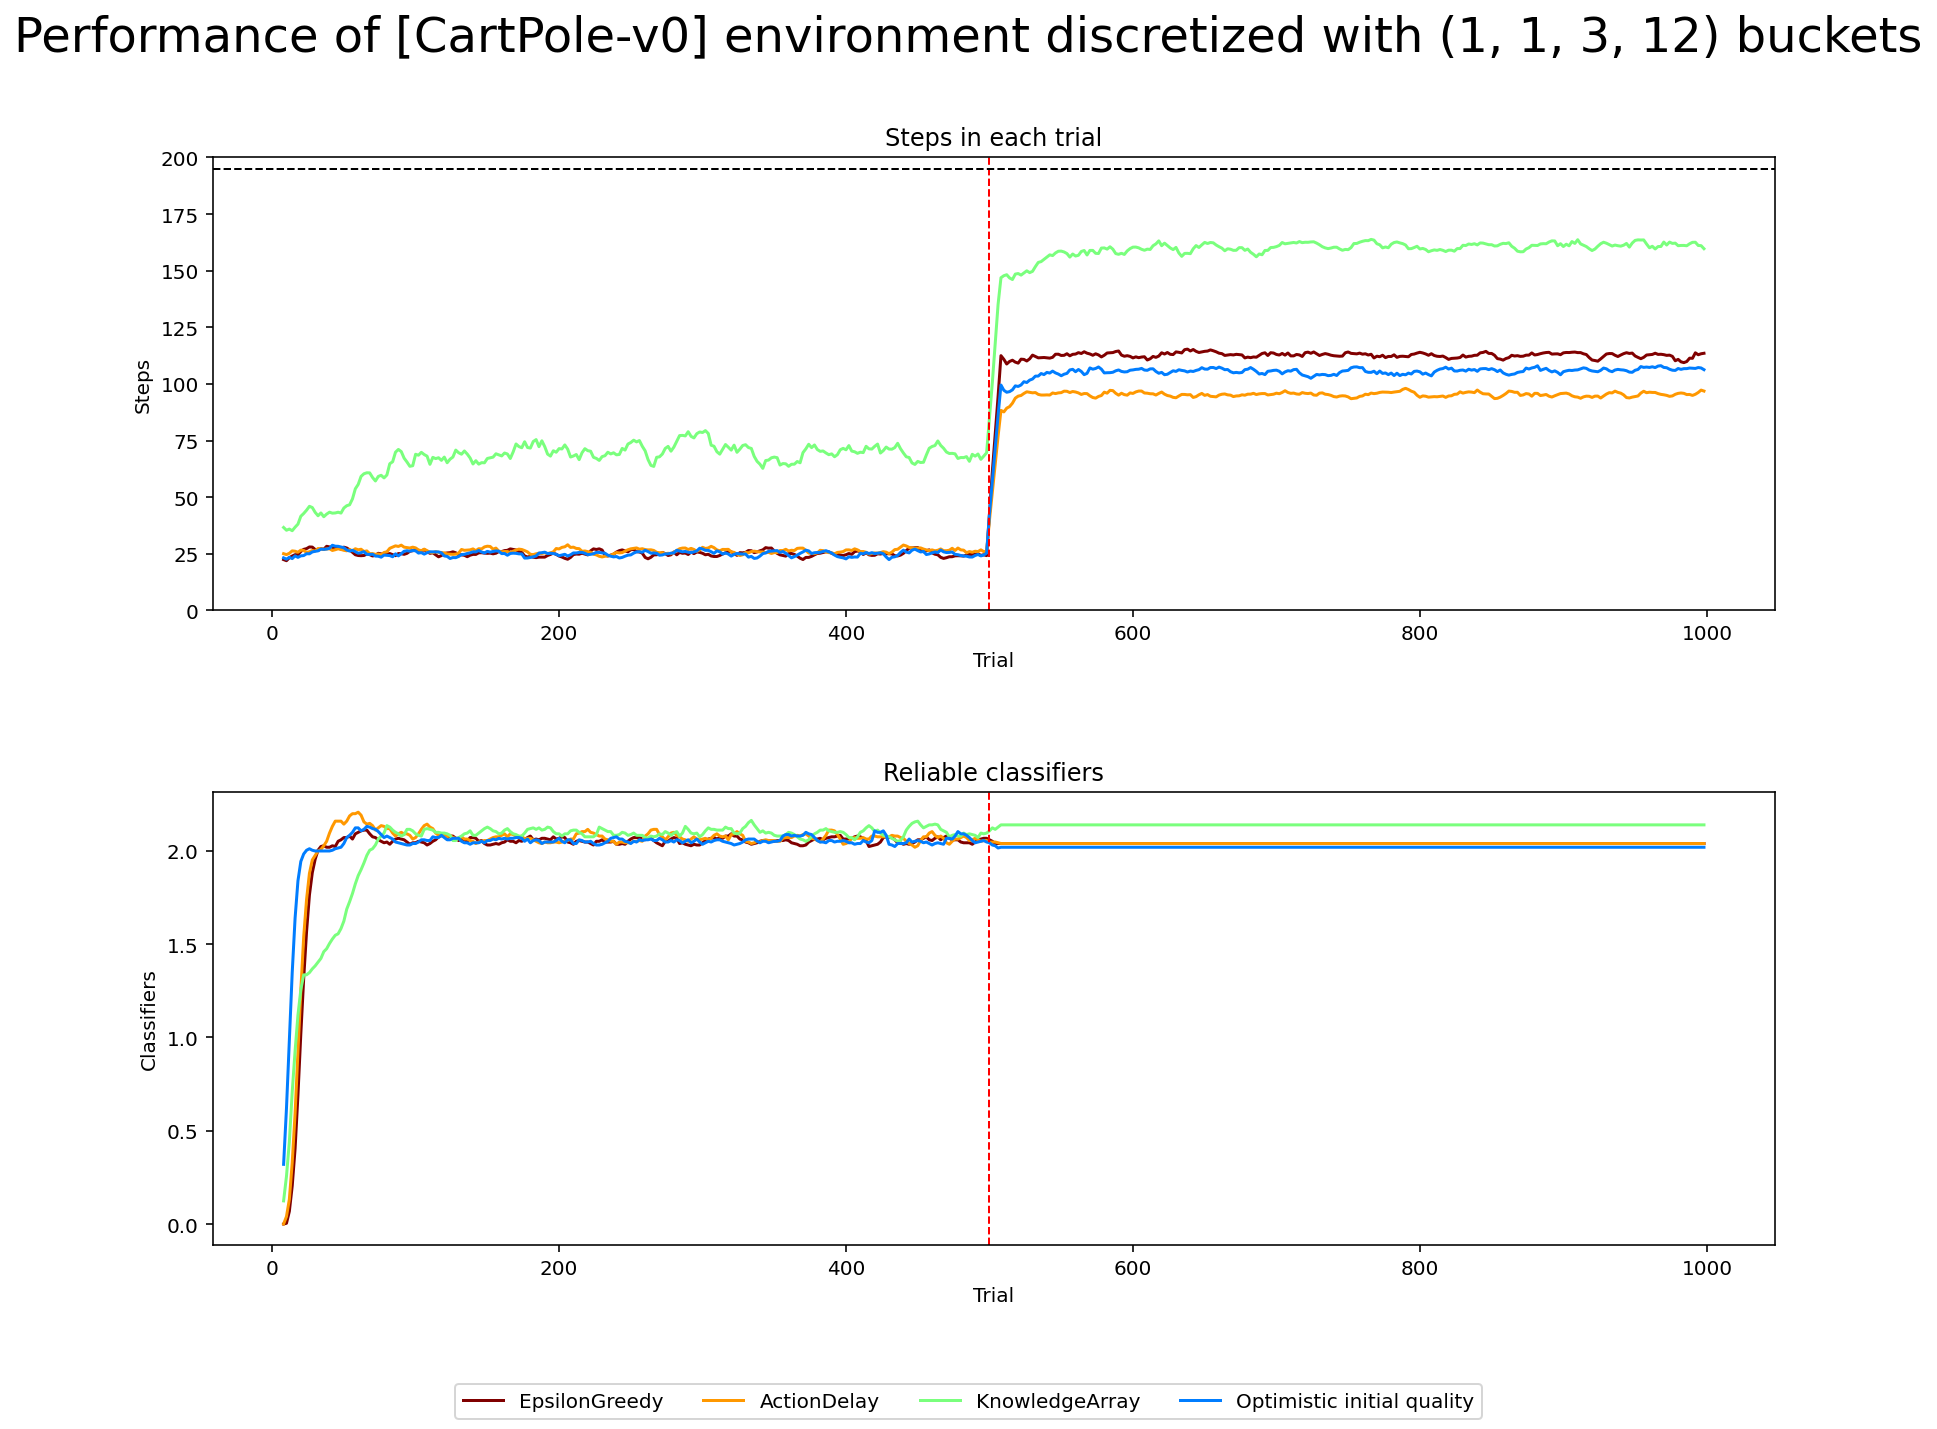

In [13]:
fig = plt.figure(figsize=(14, 10))

# Plots layout
gs = fig.add_gridspec(2,1, hspace=.4)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Global title
fig.suptitle(f'Performance of [{env.unwrapped.spec.id}] environment discretized with {buckets} buckets', fontsize=24)

# Each axis
ma_window = 5  # moving averge window

# Steps in trial
epsilon_greedy_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax1)
action_delay_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax1)
knowledge_array_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'],ax=ax1)
op_initial_df['steps_in_trial'].rolling(window=ma_window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax1)

ax1.axvline(x=explore_trials, color='red', linewidth=1, linestyle="--")
ax1.axhline(y=195, color='black', linewidth=1, linestyle="--")

ax1.set_xlabel('Trial')
ax1.set_ylabel('Steps')
ax1.set_title(f'Steps in each trial')
ax1.set_ylim(0, 200)

# Population
epsilon_greedy_df['reliable'].rolling(window=ma_window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax2)
action_delay_df['reliable'].rolling(window=ma_window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax2)
knowledge_array_df['reliable'].rolling(window=ma_window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax2)
op_initial_df['reliable'].rolling(window=ma_window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax2)

ax2.axvline(x=explore_trials, color='red', linewidth=1, linestyle="--")

ax2.set_xlabel('Trial')
ax2.set_ylabel('Classifiers')
ax2.set_title(f'Reliable classifiers')

# Create legend
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4);

# Save plot to file
fig.savefig('cartpole-performance.pdf')